In [65]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# MURA

In [66]:
import sys
sys.path.append("../../fastai/")

In [67]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [68]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [69]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/mura/data/" #Home

In [70]:
os.listdir(PATH)

['test_submission_example.csv',
 'models',
 'tmp',
 'MURA-v1.0',
 'valid.csv',
 'test',
 'cleaned_label.csv',
 'train.csv']

In [71]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_valid = pd.read_csv(f'{PATH}valid.csv')

In [72]:
df_train.head()

,MURA-v1.0/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1
0,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.0/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
3,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.0/train/XR_SHOULDER/patient00002/study...,1


In [73]:
df_train.columns = ['Image Index', 'Abnormality']

In [74]:
df_valid.columns = ['Image Index', 'Abnormality']

In [75]:
df_train.shape, df_valid.shape

((37110, 2), (3224, 2))

In [76]:
df_train['Abnormality'] = df_train['Abnormality'].astype('bool')
df_valid['Abnormality'] = df_valid['Abnormality'].astype('bool')

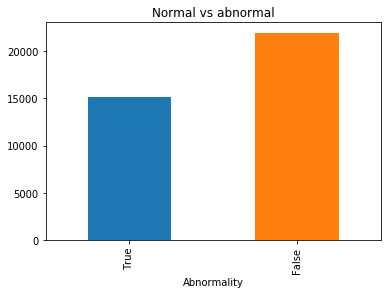

In [77]:
df_sorted = df_train.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
#df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [79]:
cleaned_label_path = f'{PATH}cleaned_label.csv'
df_train.to_csv(cleaned_label_path, index=False)

In [80]:
n = len(df_train)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [81]:
len(val_idxs)

5566

# View data

In [82]:
sz = 64
arch = dn121
bs = 16

In [83]:
#aug_tfms=transforms_side_on, max_zoom=1.1
#aug_tfms=RandomFlip()
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip(), max_zoom=1.2)
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs, val_idxs = val_idxs);

In [84]:
data = get_data(sz)

In [85]:
fn = PATH+data.trn_ds.fnames[10]
fn = '/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/MURA-v1.0/train/XR_SHOULDER/patient00012/study1_positive/image1.png' 
fn 

'/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/MURA-v1.0/train/XR_SHOULDER/patient00012/study1_positive/image1.png'

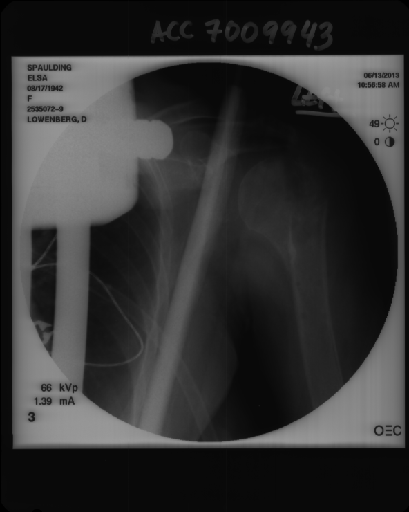

In [86]:
img = PIL.Image.open(fn);
img

In [87]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((31544,), (5566,))

# Training

In [88]:
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 

 66%|██████▋   | 1311/1972 [00:35<00:17, 37.04it/s, loss=2.72] 

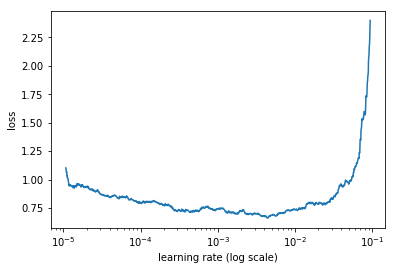

 66%|██████▋   | 1311/1972 [00:50<00:25, 26.22it/s, loss=2.72]

In [89]:
learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.0001

In [90]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

  8%|▊         | 165/1972 [00:04<00:53, 33.81it/s, loss=0.846]

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.69021    0.590108   0.68613   
    1      0.641161   0.573356   0.708947                      
    2      0.617337   0.564964   0.709486                      



[array([0.56496]), 0.7094861659650703]

In [92]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [93]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}NYNY')

epoch      trn_loss   val_loss   accuracy                      
    0      0.616255   0.572823   0.708229  
    1      0.588533   0.537492   0.734998                      
    2      0.553874   0.534538   0.738052                      



In [94]:
sz = 128

In [95]:
learn.set_data(get_data(sz))
learn.freeze()

In [96]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.552728   0.534481   0.735178  
    1      0.564643   0.525959   0.74452                       
    2      0.539107   0.524815   0.743802                      



[array([0.52482]), 0.7438016528283098]

In [97]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.509758   0.489569   0.776141  
    1      0.491012   0.463471   0.79231                       
    2      0.457614   0.45666    0.800036                      



[array([0.45666]), 0.8000359323827474]

In [98]:
learn.save(f'{sz}dn121')

In [99]:
sz = 299

In [100]:
learn.set_data(get_data(sz))
learn.freeze() 

In [101]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.513347   0.479878   0.779914  
    1      0.504863   0.470949   0.785304                      
    2      0.46341    0.472787   0.786382                      



[array([0.47279]), 0.7863816025228839]

In [102]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}0')

epoch      trn_loss   val_loss   accuracy                      
    0      0.494277   0.445665   0.805426  
    1      0.476419   0.428141   0.818721                      
    2      0.423716   0.419436   0.823212                      



In [103]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1')

epoch      trn_loss   val_loss   accuracy                      
    0      0.430975   0.417411   0.823751  
    1      0.422533   0.414268   0.825907                      
    2      0.372923   0.411267   0.826446                      



In [144]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}2')

  2%|▏         | 31/1972 [00:06<06:29,  4.98it/s, loss=0.35] 

Exception in thread Thread-43:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.39127    0.406324   0.82986   
    1      0.39557    0.411614   0.827345                      
    2      0.394477   0.407222   0.832195                      



# Prediction on test set

In [146]:
df_test = df_valid

In [165]:
len(data.test_ds.fnames)

3225

In [147]:
df_test.head()

,Image Index,Abnormality
0,test/XR_WRIST_patient11256_study1_positive_ima...,True
1,test/XR_WRIST_patient11256_study1_positive_ima...,True
2,test/XR_WRIST_patient11256_study1_positive_ima...,True
3,test/XR_WRIST_patient11257_study1_positive_ima...,True
4,test/XR_WRIST_patient11257_study1_positive_ima...,True


In [148]:
df_test.shape

(3224, 2)

In [149]:
df_test['Image Index'] = df_test['Image Index'].str.replace("/", "_")
df_test['Image Index'] = df_test['Image Index'].str.replace("test_","test/")

In [150]:
df_test.head()

,Image Index,Abnormality
0,test/XR_WRIST_patient11256_study1_positive_ima...,True
1,test/XR_WRIST_patient11256_study1_positive_ima...,True
2,test/XR_WRIST_patient11256_study1_positive_ima...,True
3,test/XR_WRIST_patient11257_study1_positive_ima...,True
4,test/XR_WRIST_patient11257_study1_positive_ima...,True


In [151]:
patient_study_idxs = {}
for stud in df_test['Image Index']:
    study_name = stud[:-11]  #eksempel: studyname = test/XR_FOREARM_patient12044_study1_positive
    if study_name not in patient_study_idxs: 
        indices = [i for i, s in enumerate(data.test_ds.fnames) if study_name in s] #posisjonen til alle som 
        patient_study_idxs[study_name] = indices

In [152]:
len(patient_study_idxs)

1209

In [153]:
patient_study_y_label = {}
for key, value in patient_study_idxs.items():
    y_string = ([x.strip() for x in key.split('_')][-1])
    y=0
    if y_string == 'positive': y=1
    patient_study_y_label[key] = y

### Predict studies 

In [154]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)

In [155]:
#value inneholder alle indeksene til et studie 
study_prediction_dict = {}
for key, value in patient_study_idxs.items(): 
    prediction_list = []
    
    for img_pos in value: 
        prediction = predict_abnormality(PATH+data.test_ds.fnames[img_pos])
        prediction_list.append(prediction)
    study_prediction_dict[key] = max(prediction_list)

In [156]:
num_correct = 0;
wrong_prediction = {}
correct_prediction = {}
for key, value in study_prediction_dict.items(): 
    xr_type = ([x.strip() for x in key.split('_')][1]) #finne riktig 
    y = patient_study_y_label[key]
    if value == y: 
        num_correct +=1
        if xr_type not in correct_prediction: 
            correct_prediction[xr_type] = 1
        else: correct_prediction[xr_type] +=1
    else: 
        if xr_type  not in wrong_prediction: 
            wrong_prediction[xr_type] = 1
        else:wrong_prediction[xr_type] +=1

In [157]:
test_accuracy = num_correct/len(study_prediction_dict)

In [158]:
print("case study accuracy: "+str(test_accuracy))

case study accuracy: 0.826302729528536


In [159]:
correct_prediction

{'WRIST': 207,
 'FOREARM': 115,
 'HAND': 138,
 'HUMERUS': 117,
 'SHOULDER': 145,
 'ELBOW': 134,
 'FINGER': 143}

In [160]:
wrong_prediction

{'WRIST': 31,
 'FOREARM': 23,
 'HAND': 29,
 'HUMERUS': 19,
 'SHOULDER': 50,
 'ELBOW': 26,
 'FINGER': 32}

In [161]:
cm = confusion_matrix(list(patient_study_y_label.values()),list(study_prediction_dict.values()));

[[548 117]
 [ 93 451]]


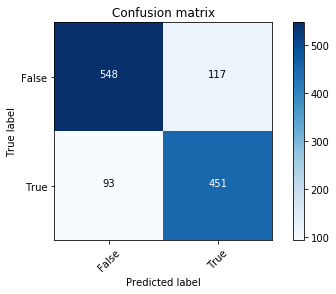

In [162]:
plot_confusion_matrix(cm, data.classes)

In [163]:
def cat_pred(correct, total): 
    return correct/total

In [164]:
for key,value in correct_prediction.items(): 
    total = value + wrong_prediction[key]
    acc = cat_pred(value, total)
    print("Accuracy for: " + key + ": " + str(acc) + "%")

Accuracy for: WRIST: 0.8697478991596639%
Accuracy for: FOREARM: 0.8333333333333334%
Accuracy for: HAND: 0.8263473053892215%
Accuracy for: HUMERUS: 0.8602941176470589%
Accuracy for: SHOULDER: 0.7435897435897436%
Accuracy for: ELBOW: 0.8375%
Accuracy for: FINGER: 0.8171428571428572%
